In [1]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
sessionNames.sort()

In [2]:
#piazza suggestion.
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [4]:
import scipy

def loadFeaturesAndNormalize(sessionPath):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()

        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data

In [5]:
import os

def getDataset(fileName):
    session_data = loadFeaturesAndNormalize(fileName)
        
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        addInterWordSymbol = True

        phonemes = []
        for p in g2p(thisTranscription):
            if addInterWordSymbol and p==' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)  # Remove stress
            if re.match(r'[A-Z]+', p):  # Only keep phonemes
                phonemes.append(p)

        #add one SIL symbol at the end so there's one at the end of each word
        if addInterWordSymbol:
            phonemes.append('SIL')

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    timeSeriesLens = []
    phoneLens = []
    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        
        zeroIdx = np.argwhere(newDataset['phonemes'][x]==0)
        phoneLens.append(zeroIdx[0,0])
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)
    return newDataset

In [ ]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

dataDir = dataDir = '/home/jupyter/neural_seq_decoder-master/competitionData'

for dayIdx in range(len(sessionNames)):
    print(dayIdx)
    trainDataset = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat')
    testDataset = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat')

    trainDatasets.append(trainDataset)
    testDatasets.append(testDataset)

    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat')
        competitionDatasets.append(dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [ ]:
dataDir = '/home/jupyter/neural_seq_decoder-master/competitionData'

competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)
print(competitionDays)

In [ ]:
import pickle

allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

with open('/home/jupyter/neural_seq_decoder-master/competitionData/CD_Datasets.pkl', 'wb') as handle:
    pickle.dump(allDatasets, handle)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(trainDatasets[0]['sentenceDat'][10].T, clim=[-1,1])
plt.show()

plt.figure(figsize=(8,2))
plt.plot(trainDatasets[0]['sentenceDat'][10][:,0])
plt.plot(trainDatasets[0]['sentenceDat'][10][:,128])
plt.xlim([0,300])
plt.ylim([-1,3])
plt.show()

In [1]:
#reuse the dataset so i can grab just a single X.
def getDatasetLoaders(
    datasetName,
    batchSize,
):
    with open(datasetName, "rb") as handle:
        loadedData = pickle.load(handle)

    def _padding(batch):
        X, y, X_lens, y_lens, days = zip(*batch)
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)

        return (
            X_padded,
            y_padded,
            torch.stack(X_lens),
            torch.stack(y_lens),
            torch.stack(days),
        )

    train_ds = SpeechDataset(loadedData["train"], transform=None)
    test_ds = SpeechDataset(loadedData["test"])

    train_loader = DataLoader(
        train_ds,
        batch_size=batchSize,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        collate_fn=_padding,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batchSize,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=_padding,
    )

    return train_loader, test_loader, loadedData


In [2]:
import torch
from torch.utils.data import Dataset


class SpeechDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.n_days = len(data)
        self.n_trials = sum([len(d["sentenceDat"]) for d in data])

        self.neural_feats = []
        self.phone_seqs = []
        self.neural_time_bins = []
        self.phone_seq_lens = []
        self.days = []
        for day in range(self.n_days):
            for trial in range(len(data[day]["sentenceDat"])):
                self.neural_feats.append(data[day]["sentenceDat"][trial])
                self.phone_seqs.append(data[day]["phonemes"][trial])
                self.neural_time_bins.append(data[day]["sentenceDat"][trial].shape[0])
                self.phone_seq_lens.append(data[day]["phoneLens"][trial])
                self.days.append(day)

    def __len__(self):
        return self.n_trials

    def __getitem__(self, idx):
        neural_feats = torch.tensor(self.neural_feats[idx], dtype=torch.float32)

        if self.transform:
            neural_feats = self.transform(neural_feats)

        return (
            neural_feats,
            torch.tensor(self.phone_seqs[idx], dtype=torch.int32),
            torch.tensor(self.neural_time_bins[idx], dtype=torch.int32),
            torch.tensor(self.phone_seq_lens[idx], dtype=torch.int32),
            torch.tensor(self.days[idx], dtype=torch.int64),
        )


In [3]:
import os
import pickle
import time

from edit_distance import SequenceMatcher
import hydra
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
def grab_X(file_path, batch_size=10):
    train_loader, test_loader, loaded_data=getDatasetLoaders(file_path, batch_size)
    #take the first batch, doesnt matter
    X, y, lenx, leny, idays = next(iter(train_loader))
    return X[:,:,:128]

In [ ]:
def check_trial_lengths(X):
    """Check if all trials have the same length"""
    batch_size, time_steps, neural_dim = X.shape
    print(f"All trials have same length: {time_steps} time steps")
    return True 
check_trial_lengths(grab_X('/home/jupyter/neural_seq_decoder-master/competitionData/CD_Datasets.pkl', batch_size=10))

In [ ]:
#creating a cool Principle component plots like the one shown in lecture\
import matplotlib.pyplot as plt
#if a manifold of neurla activity is revealed, it proves why PCA is valid. If no manifold is seen, traditional pca is not a great dimenisonality reducer and we wont use it

from sklearn.decomposition import PCA

"""draft of PCA manifold visualization function"""
# def cool_neural_manifold_visualization(X, trials_num=1):
#     #X is the same X as in the neural_decoder_trainer, likely a PYTORCH tensro, except X here has the sbp cut off
    
#     trials, times, tx_features=X.shape
    
#     #ill just plot the first trials_num plots inside a batch.
    
#     plot_these_trials = np.arange(trials_num)
    
#     #generate an array that holds the trials all flattened out so each row is a 128 featured txcrossing representation
#     #dimesniosns should be trialsxtimesteps, 128 or the other way around, idk. ill print shape to find out.
#     relevant_data= X[plot_these_trials].reshape(-1, tx_features)
    
    
#     #create a 'model' for PXCA. 
#     pca2 = PCA(n_components =2)
#     #transform our data matrix into a lower dimensional one.
#     pcaed_data=pca2.fit_transform(relevant_data)
    
    
#     #separate trials again for organization
#     principle_comp_representations =pcaed_data.reshape(trials_num, times, 2)
    
#     #plot trajectories separately,.
#     plt.figure(figsize=(15, 15))
#     plot_color="red"
    
#     #create an enumeration in case i change the logic behind trial selections later on
#     for index, trial_selected in enumerate(plot_these_trials):
#         #index into one trial
#         path2d_rep= principle_comp_representations[index]
        
#         #plot the y vs x cordinates
#         plt.plot(path2d_rep[:,0], path2d_rep[:,1], '.', alpha=0.3, color=plot_color)
        
    
def cool_neural_manifold_visualization(X, trials_num=1):

    trials, times, tx_features=X.shape
    
 
    plot_these_trials = np.arange(trials_num)
    

    relevant_data= X[plot_these_trials].reshape(-1, tx_features)
    
    

    pca2 = PCA(n_components =2)
  
    pcaed_data=pca2.fit_transform(relevant_data)
    
    
  
    principle_comp_representations =pcaed_data.reshape(trials_num, times, 2)
    
   
    plt.figure(figsize=(15, 15))
    plot_color="red"
    
    
    for index, trial_selected in enumerate(plot_these_trials):
        
        path2d_rep= principle_comp_representations[index]
        plt.figure()
        plt.plot(path2d_rep[:,0], path2d_rep[:,1], '.', alpha=0.3, color=plot_color)


In [ ]:
X=grab_X('/home/jupyter/neural_seq_decoder-master/competitionData/CD_Datasets.pkl', batch_size=1)

In [ ]:
cool_neural_manifold_visualization(X, trials_num=1)

In [1]:
import pandas as pd
NgramCER= pd.read_csv('3-gram_CER.csv')
batch= NgramCER['batchnum'].tolist()
CER=NgramCER['cer'].tolist()

In [2]:
batch = [float(_.replace('batch','').strip()) for _ in batch]

In [3]:
CER = [float(_.replace('cer:', '').strip()) for _ in CER]

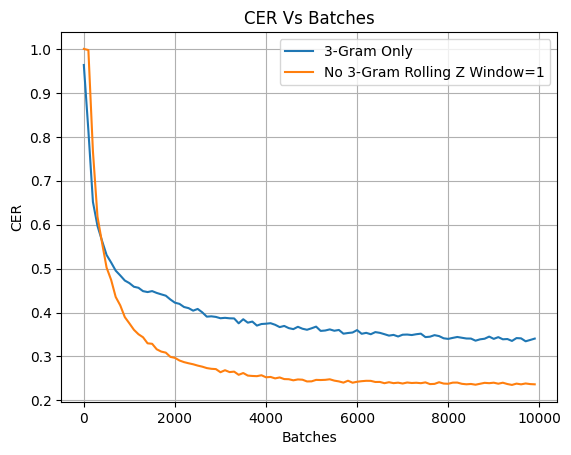

In [4]:
rollZ1=pd.read_csv('no_3Gram_1RollZ.txt')
batch1=rollZ1['batchnum'].tolist()
CER1=rollZ1['cer'].tolist()
batch1 = [float(_.replace('batch','').strip()) for _ in batch1]
CER1 = [float(_.replace('cer:', '').strip()) for _ in CER1]
import matplotlib.pyplot as plt
plt.plot(batch[0:100], CER[0:100], label='3-Gram Only' )
plt.plot(batch1, CER1, label='No 3-Gram Rolling Z Window=1' )
plt.title('CER Vs Batches')
plt.xlabel('Batches')
plt.ylabel('CER')
plt.grid()
plt.legend()

In [5]:
total_vocabulary={
    0: '', 
    1: 'AA', 
    2: 'AE',
    3: 'AH',
    4: 'AO',
    5: 'AW',  
    6: 'AY',
    7: 'B',
    8: 'CH',
    9: 'D', 
    10: 'DH' ,
    11: 'EH',
    12: 'ER',
    13: 'EY',
    14: 'F',
    15: 'G',
    16: 'HH',
    17: 'IH',
    18: 'IY',
    19: 'JH',
    20: 'K',   
    21: 'L',
    22: 'M',
    23: 'N',
    24: 'NG',
    25: 'OW',
    26: 'OY',
    27: 'P',
    28: 'R',
    29: 'S',
    30: 'SH',
    31: 'T',
    32: 'TH',
    33: 'UH',
    34: 'UW',
    35: 'V',
    36: 'W',
    37: 'Y',
    38: 'Z',
    39: 'ZH',
    40: 'SIL'
}

In [6]:
class our_LM_n:
    def __init__(self):
        self.ngrams = defaultdict(Counter)
        self.n = 3
    
    def peruse_phoneme_dictionary(self, downloaded='/home/jupyter/neural_seq_decoder-master/src/neural_decoder/USING_this_Dictionary.txt'):
        def remove_number(x):
            #remove weird numbers from phoneme dict
            return re.sub(r'\d', '', x)
        with open(downloaded, 'r', encoding='utf-8') as _:
            for every_row in _:
                if every_row.startswith(';;;'):
                    continue
                container = every_row.split()
                current_word = container[0]
                if ')' in current_word:
                    continue
                current_words_phonemes = container[1:]
                current_words_phonemes=[remove_number(_) for _ in current_words_phonemes]
                for j in range(len(current_words_phonemes) - self.n + 1):
                    prior = tuple(current_words_phonemes[j:j + self.n - 1])
                    prediction = current_words_phonemes[j + self.n - 1]
                    self.ngrams[prior][prediction] = self.ngrams[prior][prediction] + 1
                    
    def probability_of_arbitrary_phonemeseq(self, arbitrary_phoneme_seq):
        arbitrary_word_in_phoneme_representation = [total_vocabulary[_] for _ in arbitrary_phoneme_seq if _ != 0]
        if len(arbitrary_word_in_phoneme_representation) < self.n:
            return 0.00 
        arbitrary_word_in_phoneme = ' '.join(arbitrary_word_in_phoneme_representation)
        if arbitrary_word_in_phoneme.strip() == '':
            return 0.00 
        key_count = len(self.ngrams)       
        ln_prob = 0.00
      
        for k in range(len(arbitrary_word_in_phoneme_representation) - self.n + 1):
            prior = tuple(arbitrary_word_in_phoneme_representation[k:k + self.n - 1])
            predict = arbitrary_word_in_phoneme_representation[k + self.n - 1]
            occurences = self.ngrams[prior].get(predict, 0)
            every_occurence = sum(self.ngrams[prior].values())
            temp_prob = 10**-8
            if every_occurence == 0:
                temp_prob = 10**-8
            else:
                temp_prob = max(10**-8, occurences / every_occurence)
            ln_prob = ln_prob + math.log(temp_prob)
        return ln_prob

In [7]:
import math
import pickle
from collections import defaultdict, Counter
import re
my_lm = our_LM_n()
my_lm.peruse_phoneme_dictionary('/home/jupyter/neural_seq_decoder-master/src/neural_decoder/USING_this_Dictionary.txt')

In [8]:
#confirm LM scoring makes sense.
print(my_lm.probability_of_arbitrary_phonemeseq([29, 11, 21]))#S EH L (sell) #well known
print(my_lm.probability_of_arbitrary_phonemeseq([38, 11, 21]))#Z EH L (zell) #not really common
print(my_lm.probability_of_arbitrary_phonemeseq([8, 11, 21]))#CH EH L (Chell) #not really common
print(my_lm.probability_of_arbitrary_phonemeseq([14, 1, 31]))#F AA T (fat) #well known word
print(my_lm.probability_of_arbitrary_phonemeseq([7, 1, 31]))#B AA T (bat) #well known word
print(my_lm.probability_of_arbitrary_phonemeseq([35, 11, 31]))#V AA T (vat) #well known word
print(my_lm.probability_of_arbitrary_phonemeseq([38, 39, 35]))#Z ZH V (absolute gibberish)

-1.5538074304151297
-1.4686306477805264
-2.0704728716970755
-3.8559335387771023
-2.805852815880294
-2.6122460721646017
-18.420680743952367


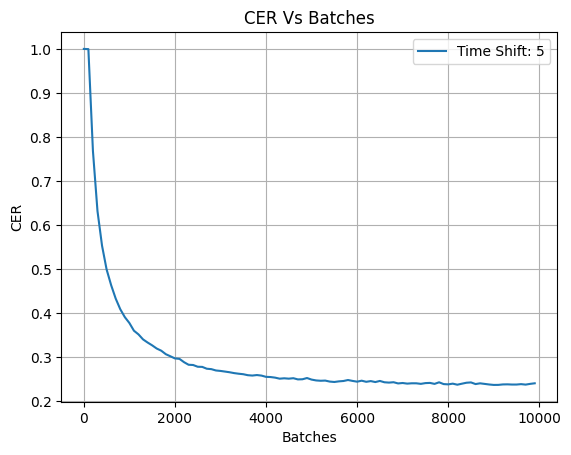

In [9]:
rollZ1=pd.read_csv('time_shift.txt')
batch1=rollZ1['batchnum'].tolist()
CER1=rollZ1['cer'].tolist()
batch1 = [float(_.replace('batch','').strip()) for _ in batch1]
CER1 = [float(_.replace('cer:', '').strip()) for _ in CER1]
import matplotlib.pyplot as plt
plt.plot(batch1[0:100], CER1[0:100], label='Time Shift: 5' )
plt.title('CER Vs Batches')
plt.xlabel('Batches')
plt.ylabel('CER')
plt.grid()
plt.legend()

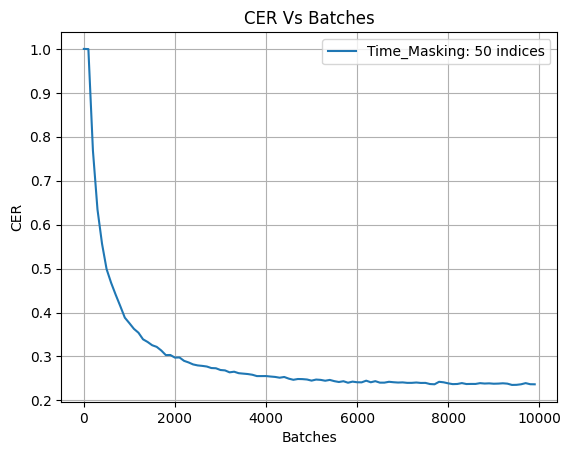

In [10]:
rollZ1=pd.read_csv('time_masking.txt')
batch1=rollZ1['batchnum'].tolist()
CER1=rollZ1['cer'].tolist()
batch1 = [float(_.replace('batch','').strip()) for _ in batch1]
CER1 = [float(_.replace('cer:', '').strip()) for _ in CER1]
import matplotlib.pyplot as plt
plt.plot(batch1[0:100], CER1[0:100], label='Time Masking: 50 indices' )
plt.title('CER Vs Batches')
plt.xlabel('Batches')
plt.ylabel('CER')
plt.grid()
plt.legend()

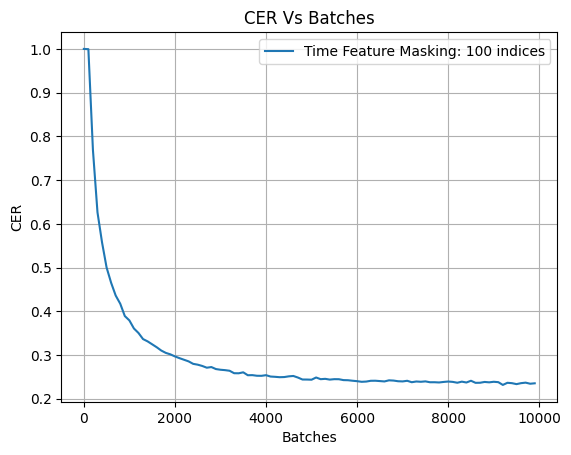

In [12]:
rollZ1=pd.read_csv('time_feature_masking.txt')
batch1=rollZ1['batchnum'].tolist()
CER1=rollZ1['cer'].tolist()
batch1 = [float(_.replace('batch','').strip()) for _ in batch1]
CER1 = [float(_.replace('cer:', '').strip()) for _ in CER1]
import matplotlib.pyplot as plt
plt.plot(batch1[0:100], CER1[0:100], label='Time Feature Masking: 100 indices' )
plt.title('CER Vs Batches')
plt.xlabel('Batches')
plt.ylabel('CER')
plt.grid()
plt.legend()

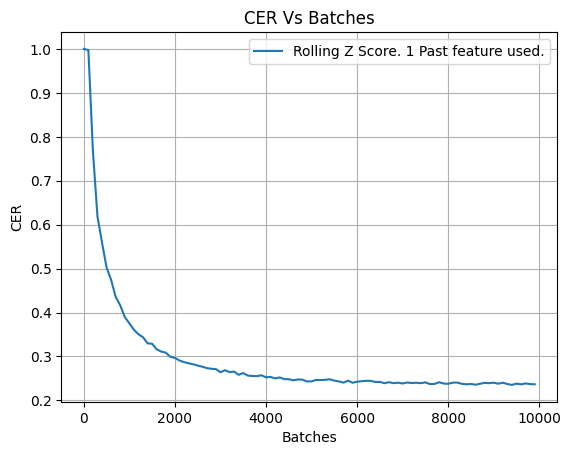

In [14]:
rollZ1=pd.read_csv('no_3Gram_1RollZ.txt')
batch1=rollZ1['batchnum'].tolist()
CER1=rollZ1['cer'].tolist()
batch1 = [float(_.replace('batch','').strip()) for _ in batch1]
CER1 = [float(_.replace('cer:', '').strip()) for _ in CER1]
import matplotlib.pyplot as plt
plt.plot(batch1[0:100], CER1[0:100], label='Rolling Z Score. 1 Past feature used.' )
plt.title('CER Vs Batches')
plt.xlabel('Batches')
plt.ylabel('CER')
plt.grid()
plt.legend()

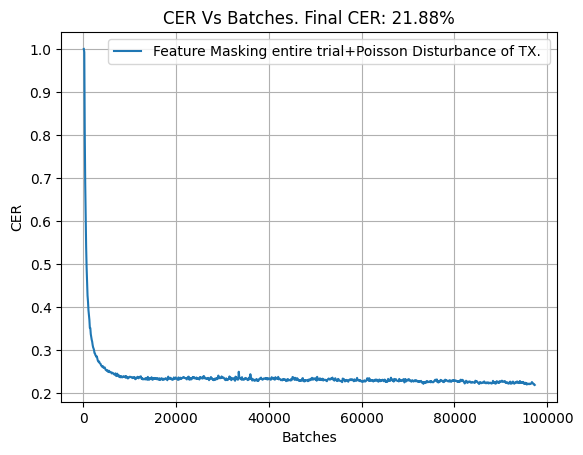

In [20]:
rollZ1=pd.read_csv('feature_mask_poisson.txt')
batch1=rollZ1['batchnum'].tolist()
CER1=rollZ1['cer'].tolist()
batch1 = [float(_.replace('batch','').strip()) for _ in batch1]
CER1 = [float(_.replace('cer:', '').strip()) for _ in CER1]
import matplotlib.pyplot as plt
plt.plot(batch1, CER1, label='Feature Masking entire trial+Poisson Disturbance of TX. ' )
plt.title('CER Vs Batches. Final CER: 21.88%')
plt.xlabel('Batches')
plt.ylabel('CER')
plt.grid()
plt.legend()